In [1]:
# Gap Up Identifier - Jupyter Notebook
import pandas as pd
pd.set_option('display.width', 160)
pd.set_option('display.max_rows', 10) 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
import mplfinance as mpf
import datetime as dt
from _Utils import Utils

In [2]:
#csv_file = 'ES(495512563)(1 hour)_historical_data.csv'
# csv_file = 'ES(495512563)(1 hour)(2 Y)_historical_data.csv'
# csv_file = 'ES(495512563)(1 hour)(3 M)_historical_data.csv'
csv_file = 'ES(495512563)(1 day)(3 M)_historical_data.csv'
# csv_file = 'test.csv'


initial_capital = 10000  
position_size = 0.95 
gap_threshold = 0.15



In [3]:
def load_data(csv_file):
    """Load and prepare OHLC data"""
    df = pd.read_csv(csv_file, parse_dates=True)
    df.columns = df.columns.str.lower()
    df.index = pd.DatetimeIndex(df['date'])
    
    required_cols = ['open', 'close', 'high', 'low']
    if not all(col in df.columns for col in required_cols):
        raise ValueError(f"CSV must contain {required_cols}. Found: {list(df.columns)}")
    
    
    df['date'] = pd.to_datetime(df['date'])
    # df = df.sort_values('date').reset_index(drop=True)

    
    # Calculate gaps
    df['is_market_open'] = False
    df['is_market_close'] = False

    opening_bars = df.groupby(df['date'].dt.floor('1D')).head(1)
    closing_bars = df.groupby(df['date'].dt.floor('1D')).tail(1)

    df.loc[df['date'].isin(opening_bars['date']), 'is_market_open'] = True
    df.loc[df['date'].isin(closing_bars['date']), 'is_market_close'] = True

    # print("opening_bars")
    # print(opening_bars.head(3))
    # print("closing_bars")
    # print(closing_bars.head(3))

    df_daily = df[(df['is_market_open'] == True) | (df['is_market_close'] == True)].copy()
    df_daily["prev_close"] = None
    df_daily["gap_pct"] = None
    df_daily.loc[df['is_market_open'] == True, 'prev_close'] = df_daily['close'].shift(1)
    df_daily.loc[df['is_market_open'] == True, 'gap_pct'] = ((df_daily['open'] - df_daily['prev_close']) / df_daily['prev_close']) * 100
    df_daily["is_gap_up"] = False
    df_daily['is_gap_up'] = df_daily['gap_pct'] > gap_threshold


    

    # print(df_daily)
    df_gap_up = df_daily[df_daily['is_gap_up'] == True]
    # print(df_gap_up)

    df.loc[df['date'].isin(df_gap_up['date']), ['gap_pct', 'is_gap_up']] = df_gap_up[['gap_pct', 'is_gap_up']]

    
    # df['dateDay'] = df['date'].dt.normalize()

    # col = df.pop('dateDay')
    # df.insert(0, 'dateDay',col)

    # print(df[df['is_gap_up'] == True])

    return df


df = load_data(csv_file)
# print(f"Data loaded: {len(df)} rows")
# print(f"Gap ups found: {df['is_gap_up'].sum()}")
# print(f"Date range: {df['date'].min()} to {df['date'].max()}")

print(df[df['is_gap_up'] == True])
# print(df)

                 date     open     high      low    close   volume  is_market_open  is_market_close   gap_pct is_gap_up
date                                                                                                                   
2025-09-15 2025-09-15  6666.50  6681.25  6663.25  6679.25   621252            True             True  0.323552      True
2025-09-18 2025-09-18  6686.75  6718.00  6670.25  6693.50  1092361            True             True  0.420499      True
2025-09-19 2025-09-19  6707.25  6731.50  6687.25  6722.50  1054918            True             True  0.205423      True
2025-09-24 2025-09-24  6727.25  6728.50  6678.00  6692.25  1072814            True             True  0.182427      True
2025-09-26 2025-09-26  6673.50  6703.75  6657.25  6696.50  1093048            True             True  0.206464      True
...               ...      ...      ...      ...      ...      ...             ...              ...       ...       ...
2025-11-21 2025-11-21  6581.50  6677.50 

In [4]:
class Trade:
    def __init__(self, entry_date, entry_price, shares, strategy_name):
        self.entry_date = entry_date
        self.entry_price = entry_price
        self.shares = shares
        self.exit_date = None
        self.exit_price = None
        self.pnl = 0
        self.return_pct = 0
        self.strategy_name = strategy_name
        self.exit_reason = None

def backtest_strategy(df, strategy_params, initial_capital, position_size, strategy_name):
    """Backtest a single strategy"""
    capital = initial_capital
    trades = []
    active_trade = None
    equity_curve = []
    
    hold_days = strategy_params['hold_days']
    stop_loss = strategy_params.get('stop_loss')
    take_profit = strategy_params.get('take_profit')
    fade = strategy_params.get('fade', False)  # Fade = short the gap
    
    for i in range(len(df)):
        current_row = df.iloc[i]
        date = current_row['date']
        
        # Track equity
        if active_trade:
            current_value = capital + (active_trade.shares * current_row['close'])
        else:
            current_value = capital
        equity_curve.append({'date': date, 'equity': current_value})
        
        # Check if we need to exit an active trade
        if active_trade:
            days_held = Utils.busday_diff(active_trade.entry_date, date)
            # print(active_trade.entry_date, date, "days_held", days_held)
            current_price = current_row['close']
            
            # Calculate current return
            if fade:
                current_return = ((active_trade.entry_price - current_price) / active_trade.entry_price) * 100
            else:
                current_return = ((current_price - active_trade.entry_price) / active_trade.entry_price) * 100
            
            should_exit = False
            exit_reason = None
            
            # Check stop loss
            if stop_loss and current_return <= -stop_loss:
                should_exit = True
                exit_reason = 'Stop Loss'
            
            # Check take profit
            elif take_profit and current_return >= take_profit:
                should_exit = True
                exit_reason = 'Take Profit'
            
            # Check holding period
            elif days_held >= hold_days:
                should_exit = True
                exit_reason = f'Hold Period ({hold_days}d)'
            
            if should_exit:
                # Exit trade
                active_trade.exit_date = date
                active_trade.exit_price = current_price
                
                if fade:
                    active_trade.pnl = active_trade.shares * (active_trade.entry_price - current_price)
                else:
                    active_trade.pnl = active_trade.shares * (current_price - active_trade.entry_price)
                
                active_trade.return_pct = current_return
                active_trade.exit_reason = exit_reason
                
                capital += active_trade.shares * active_trade.entry_price + active_trade.pnl
                trades.append(active_trade)
                active_trade = None
        
        # Check for new gap up signal (only if no active trade)
        if not active_trade and current_row['is_gap_up'] and i > 0:
            entry_price = current_row['open']
            shares = int((capital * position_size) / entry_price)
            
            if shares > 0:
                active_trade = Trade(date, entry_price, shares, strategy_name)
                capital -= shares * entry_price
    
    # Close any remaining open trade
    if active_trade:
        last_row = df.iloc[-1]
        active_trade.exit_date = last_row['date']
        active_trade.exit_price = last_row['close']
        
        if fade:
            active_trade.pnl = active_trade.shares * (active_trade.entry_price - last_row['close'])
            active_trade.return_pct = ((active_trade.entry_price - last_row['close']) / active_trade.entry_price) * 100
        else:
            active_trade.pnl = active_trade.shares * (last_row['close'] - active_trade.entry_price)
            active_trade.return_pct = ((last_row['close'] - active_trade.entry_price) / active_trade.entry_price) * 100
        
        active_trade.exit_reason = 'End of Data'
        capital += active_trade.shares * active_trade.entry_price + active_trade.pnl
        trades.append(active_trade)
    
    return {
        'trades': trades,
        'final_capital': capital,
        'equity_curve': pd.DataFrame(equity_curve)
    }

In [5]:
strategies = {
    'hold_1_days': {'hold_days': 1, 'stop_loss': 2.0, 'take_profit': None},
    'hold_5_days': {'hold_days': 5, 'stop_loss': None, 'take_profit': None},
    'stop_loss_2pct': {'hold_days': 10, 'stop_loss': 2.0, 'take_profit': 5.0},
    'aggressive': {'hold_days': 1, 'stop_loss': None, 'take_profit': None},
    'fade_gap': {'hold_days': 1, 'stop_loss': 3.0, 'take_profit': 2.0, 'fade': True}
}

In [6]:
print("\n" + "="*80)
print("BACKTESTING ALL STRATEGIES")
print("="*80)

results = {}
for strategy_name, params in strategies.items():
    result = backtest_strategy(df, params, initial_capital, position_size, strategy_name)
    results[strategy_name] = result
    
    # Calculate metrics
    trades = result['trades']
    if len(trades) > 0:
        winning_trades = [t for t in trades if t.pnl > 0]
        losing_trades = [t for t in trades if t.pnl <= 0]
        
        total_return = ((result['final_capital'] - initial_capital) / initial_capital) * 100
        win_rate = (len(winning_trades) / len(trades)) * 100
        avg_win = np.mean([t.pnl for t in winning_trades]) if winning_trades else 0
        avg_loss = np.mean([t.pnl for t in losing_trades]) if losing_trades else 0
        
        print(f"\n{strategy_name.upper().replace('_', ' ')}")
        print("-" * 40)
        print(f"Total Trades: {len(trades)}")
        print(f"Winning Trades: {len(winning_trades)}")
        print(f"Losing Trades: {len(losing_trades)}")
        print(f"Win Rate: {win_rate:.2f}%")
        print(f"Total Return: {total_return:.2f}%")
        print(f"Final Capital: ${result['final_capital']:,.2f}")
        print(f"Avg Win: ${avg_win:.2f}")
        print(f"Avg Loss: ${avg_loss:.2f}")
        if avg_loss != 0:
            print(f"Profit Factor: {abs(avg_win/avg_loss):.2f}")
    else:
        print(f"\n{strategy_name}: No trades executed")


BACKTESTING ALL STRATEGIES

HOLD 1 DAYS
----------------------------------------
Total Trades: 62
Winning Trades: 35
Losing Trades: 27
Win Rate: 56.45%
Total Return: 0.83%
Final Capital: $10,083.25
Avg Win: $47.69
Avg Loss: $-58.74
Profit Factor: 0.81

HOLD 5 DAYS
----------------------------------------
Total Trades: 13
Winning Trades: 8
Losing Trades: 5
Win Rate: 61.54%
Total Return: 3.73%
Final Capital: $10,373.00
Avg Win: $81.94
Avg Loss: $-56.50
Profit Factor: 1.45

STOP LOSS 2PCT
----------------------------------------
Total Trades: 7
Winning Trades: 4
Losing Trades: 3
Win Rate: 57.14%
Total Return: 2.86%
Final Capital: $10,286.25
Avg Win: $129.00
Avg Loss: $-76.58
Profit Factor: 1.68

AGGRESSIVE
----------------------------------------
Total Trades: 62
Winning Trades: 35
Losing Trades: 27
Win Rate: 56.45%
Total Return: 0.83%
Final Capital: $10,083.25
Avg Win: $47.69
Avg Loss: $-58.74
Profit Factor: 0.81

FADE GAP
----------------------------------------
Total Trades: 62
Winnin

In [7]:
best_strategy = max(results.items(), key=lambda x: x[1]['final_capital'])
print("\n" + "="*80)
print(f"BEST STRATEGY: {best_strategy[0].upper().replace('_', ' ')}")
print("="*80)

trades_df = pd.DataFrame([{
    'Entry Date': t.entry_date,
    'Exit Date': t.exit_date,
    'Entry Price': f"${t.entry_price:.2f}",
    'Exit Price': f"${t.exit_price:.2f}",
    'Shares': t.shares,
    'P&L': f"${t.pnl:.2f}",
    'Return %': f"{t.return_pct:.2f}%",
    'Exit Reason': t.exit_reason
} for t in best_strategy[1]['trades']])

print("\nTrade History:")
print(trades_df.to_string(index=False))


BEST STRATEGY: HOLD 5 DAYS

Trade History:
Entry Date  Exit Date Entry Price Exit Price  Shares      P&L Return %      Exit Reason
2025-09-15 2025-09-22    $6666.50   $6752.50       1   $86.00    1.29% Hold Period (5d)
2025-09-22 2025-09-29    $6706.00   $6713.50       1    $7.50    0.11% Hold Period (5d)
2025-09-29 2025-10-06    $6722.25   $6788.75       1   $66.50    0.99% Hold Period (5d)
2025-10-06 2025-10-13    $6788.75   $6694.75       1  $-94.00   -1.38% Hold Period (5d)
2025-10-13 2025-10-20    $6670.25   $6773.75       1  $103.50    1.55% Hold Period (5d)
2025-10-20 2025-10-27    $6733.25   $6908.25       1  $175.00    2.60% Hold Period (5d)
2025-10-27 2025-11-03    $6883.00   $6882.75       1   $-0.25   -0.00% Hold Period (5d)
2025-11-03 2025-11-10    $6908.25   $6856.75       1  $-51.50   -0.75% Hold Period (5d)
2025-11-10 2025-11-17    $6815.75   $6692.00       1 $-123.75   -1.82% Hold Period (5d)
2025-11-17 2025-11-24    $6734.25   $6721.25       1  $-13.00   -0.19% Hold 

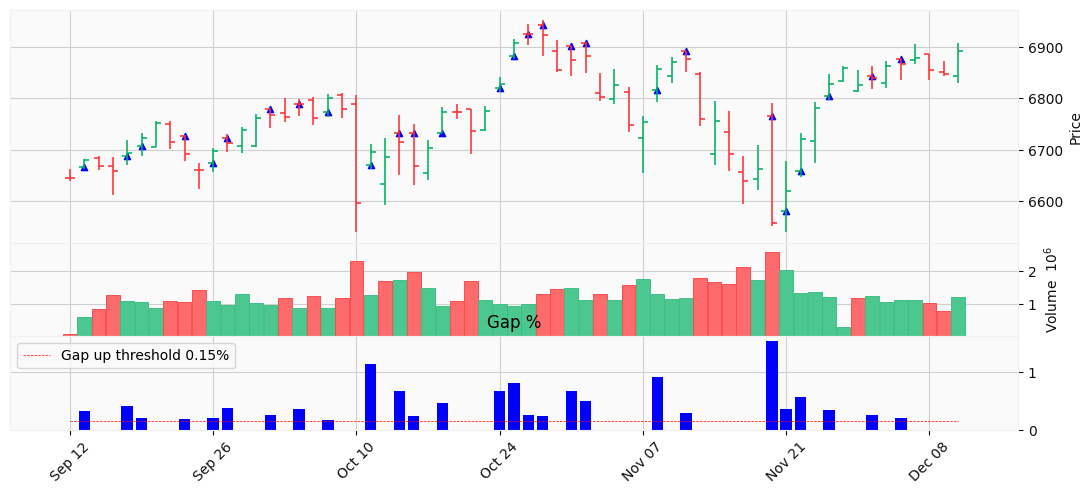

In [26]:
# mask = (df['date'] > "2025-09-25") & (df['date'] <= "2025-10-15")
# mask = (df['date'] >= "2025-09-27") & (df['date'] <= "2025-09-30")
# pts = df.loc[mask].copy()
pts = df.copy()

buy_signals = pd.Series(np.nan, index=pts.index)


condition = pts['is_gap_up'] == True
buy_signals[condition] = pts['open'][condition]

# print(pts)
# print(buy_signals)
pts['support_line'] = [gap_threshold] * len(pts)

apd = [
    mpf.make_addplot(buy_signals, type='scatter', markersize=20, marker='^', color='b'),
    # mpf.make_addplot(pts['open'], type='scatter', markersize=10, marker='^', color='b'),
    # mpf.make_addplot(pts['close'], type='scatter', markersize=10, marker='v', color='b'),
    # ^v
    mpf.make_addplot(pts['gap_pct'], type='bar', panel=2, color='b', ylabel="Gap %", secondary_y=False),
    mpf.make_addplot(pts['support_line'], type='line', width=0.5, panel=2, color='r', linestyle="--", label=f"Gap up threshold {gap_threshold}%", secondary_y=False),
]
#greater than the start date and smaller than the end date


fig, axlist = mpf.plot(pts, addplot=apd, type='ohlc', figsize=(14, 6), style='yahoo', volume=True, returnfig=True)

/var/folders/gj/6h753jdn6mj4z40p9vghk3d80000gp/T/ipykernel_16319/1852086530.py:85: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


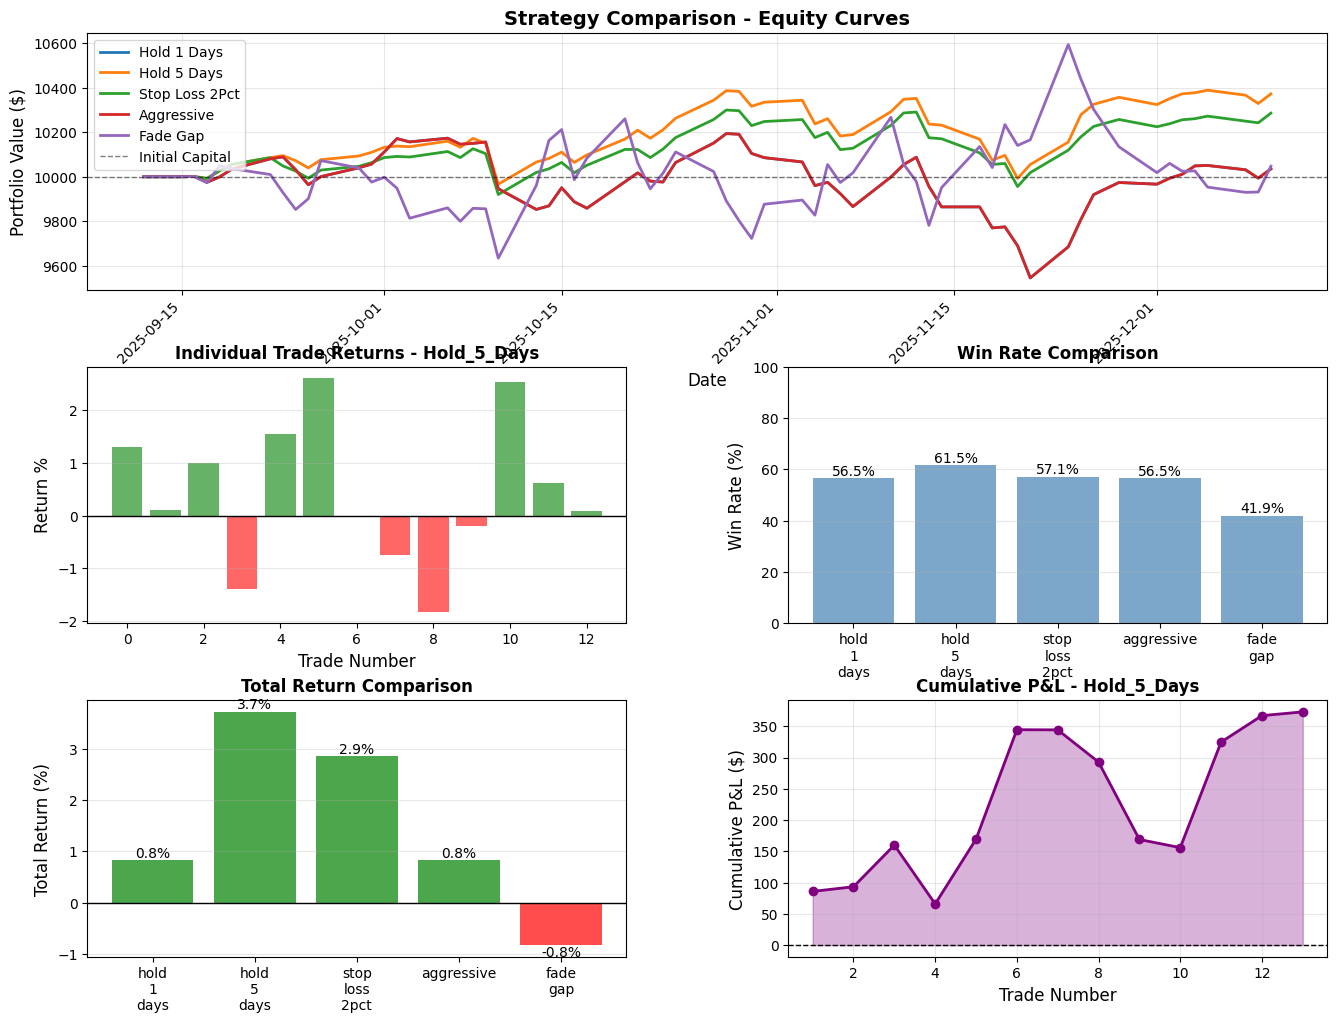


BACKTESTING COMPLETE


In [8]:
fig = plt.figure(figsize=(16, 12))
gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)

# Plot 1: Equity curves comparison
ax1 = fig.add_subplot(gs[0, :])
for strategy_name, result in results.items():
    if len(result['trades']) > 0:
        ec = result['equity_curve']
        ax1.plot(ec['date'], ec['equity'], label=strategy_name.replace('_', ' ').title(), linewidth=2)

ax1.axhline(y=initial_capital, color='black', linestyle='--', linewidth=1, alpha=0.5, label='Initial Capital')
ax1.set_xlabel('Date', fontsize=12)
ax1.set_ylabel('Portfolio Value ($)', fontsize=12)
ax1.set_title('Strategy Comparison - Equity Curves', fontsize=14, fontweight='bold')
ax1.legend(loc='best')
ax1.grid(True, alpha=0.3)
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')

# Plot 2: Returns distribution for best strategy
ax2 = fig.add_subplot(gs[1, 0])
returns = [t.return_pct for t in best_strategy[1]['trades']]
colors = ['green' if r > 0 else 'red' for r in returns]
ax2.bar(range(len(returns)), returns, color=colors, alpha=0.6)
ax2.axhline(y=0, color='black', linewidth=1)
ax2.set_xlabel('Trade Number', fontsize=12)
ax2.set_ylabel('Return %', fontsize=12)
ax2.set_title(f'Individual Trade Returns - {best_strategy[0].title()}', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')

# Plot 3: Win/Loss distribution
ax3 = fig.add_subplot(gs[1, 1])
strategy_names = []
win_rates = []
for name, result in results.items():
    if len(result['trades']) > 0:
        wins = len([t for t in result['trades'] if t.pnl > 0])
        win_rate = (wins / len(result['trades'])) * 100
        strategy_names.append(name.replace('_', '\n'))
        win_rates.append(win_rate)

bars = ax3.bar(strategy_names, win_rates, color='steelblue', alpha=0.7)
ax3.set_ylabel('Win Rate (%)', fontsize=12)
ax3.set_title('Win Rate Comparison', fontsize=12, fontweight='bold')
ax3.set_ylim(0, 100)
ax3.grid(True, alpha=0.3, axis='y')
for bar, rate in zip(bars, win_rates):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
            f'{rate:.1f}%', ha='center', va='bottom', fontsize=10)

# Plot 4: Total returns comparison
ax4 = fig.add_subplot(gs[2, 0])
strategy_names = []
total_returns = []
for name, result in results.items():
    if len(result['trades']) > 0:
        ret = ((result['final_capital'] - initial_capital) / initial_capital) * 100
        strategy_names.append(name.replace('_', '\n'))
        total_returns.append(ret)

colors = ['green' if r > 0 else 'red' for r in total_returns]
bars = ax4.bar(strategy_names, total_returns, color=colors, alpha=0.7)
ax4.axhline(y=0, color='black', linewidth=1)
ax4.set_ylabel('Total Return (%)', fontsize=12)
ax4.set_title('Total Return Comparison', fontsize=12, fontweight='bold')
ax4.grid(True, alpha=0.3, axis='y')
for bar, ret in zip(bars, total_returns):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height,
            f'{ret:.1f}%', ha='center', va='bottom' if height > 0 else 'top', fontsize=10)

# Plot 5: Cumulative P&L for best strategy
ax5 = fig.add_subplot(gs[2, 1])
cumulative_pnl = np.cumsum([t.pnl for t in best_strategy[1]['trades']])
trade_numbers = range(1, len(cumulative_pnl) + 1)
ax5.plot(trade_numbers, cumulative_pnl, marker='o', linewidth=2, markersize=6, color='purple')
ax5.axhline(y=0, color='black', linestyle='--', linewidth=1)
ax5.fill_between(trade_numbers, cumulative_pnl, 0, alpha=0.3, color='purple')
ax5.set_xlabel('Trade Number', fontsize=12)
ax5.set_ylabel('Cumulative P&L ($)', fontsize=12)
ax5.set_title(f'Cumulative P&L - {best_strategy[0].title()}', fontsize=12, fontweight='bold')
ax5.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("BACKTESTING COMPLETE")
print("="*80)